In [58]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [59]:
os.path.abspath(os.curdir)

'/mnt/c/Users/crulis/Documents/projects/yolo_tdid_github'

In [60]:
result_dir = Path('results_wc_eps')
files = list(result_dir.glob('*.csv'))

In [61]:
files

[PosixPath('results_wc_eps/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-10_bias-False_augment-True_use_wc-True_seed-805393.csv'),
 PosixPath('results_wc_eps/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-1_bias-False_augment-True_use_wc-True_seed-172468.csv'),
 PosixPath('results_wc_eps/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-3_bias-False_augment-True_use_wc-True_seed-472379.csv'),
 PosixPath('results_wc_eps/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-5_bias-False_augment-True_use_wc-True_seed-708876.csv'),
 PosixPath('results_wc_eps/yolow-l_sighted-True_clutter-False_hand-False_n-2_k-10_bias-False_augment-True_use_wc-True_seed-62997.csv'),
 PosixPath('results_wc_eps/yolow-l_sighted-True_clutter-False_hand-False_n-2_k-1_bias-False_augment-True_use_wc-True_seed-496509.csv'),
 PosixPath('results_wc_eps/yolow-l_sighted-True_clutter-False_hand-False_n-2_k-3_bias-False_augment-True_use_wc-True_seed-296697.csv'),
 PosixPath('results_wc_eps/yolow-l_sighted-

append model size column

In [62]:
files[0].stem

'yolow-l_sighted-True_clutter-False_hand-False_n-19_k-10_bias-False_augment-True_use_wc-True_seed-805393'

In [63]:
name_re = re.compile(r'yolow-(.)_sighted-(.+)_clutter-(.+)_hand-(.+)_n-(\d+)_k-(\d+)_bias-.+_augment-(.+)_use_wc-(.+)_seed-(\d+).*')

dfs = []

for f in files:
    m = name_re.match(f.stem)
    if m is None:
        print(f"Skipping {f}")
        continue
    df = pd.read_csv(f)
    df['size'] = m.group(1)
    df['train blind'] = m.group(2) == "False"
    df['train clutter'] = m.group(3) == "True"
    df['train hand'] = m.group(4) == "True"
    df['n_objects'] = int(m.group(5))
    df['k_examples'] = int(m.group(6))
    df['augment'] = m.group(7) == "True"
    df['WC'] = m.group(8) == "True"
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [64]:
dfs[0].columns

Index(['repeat', 'seed', 'hand', 'blind', 'illuminated', 'torch',
       'volume_portrait', 'clutter', 'target_class', 'predicted_class',
       'predicted_prob', 'correct', 'prob_cls_0', 'prob_cls_1', 'prob_cls_2',
       'prob_cls_3', 'prob_cls_4', 'prob_cls_5', 'prob_cls_6', 'prob_cls_7',
       'prob_cls_8', 'prob_cls_9', 'prob_cls_10', 'prob_cls_11', 'prob_cls_12',
       'prob_cls_13', 'prob_cls_14', 'prob_cls_15', 'prob_cls_16',
       'prob_cls_17', 'prob_cls_18', 'size', 'train blind', 'train clutter',
       'train hand', 'n_objects', 'k_examples', 'augment', 'WC'],
      dtype='object')

In [65]:
df.columns

Index(['repeat', 'seed', 'hand', 'blind', 'illuminated', 'torch',
       'volume_portrait', 'clutter', 'target_class', 'predicted_class',
       'predicted_prob', 'correct', 'prob_cls_0', 'prob_cls_1', 'prob_cls_2',
       'prob_cls_3', 'prob_cls_4', 'prob_cls_5', 'prob_cls_6', 'prob_cls_7',
       'prob_cls_8', 'prob_cls_9', 'prob_cls_10', 'prob_cls_11', 'prob_cls_12',
       'prob_cls_13', 'prob_cls_14', 'prob_cls_15', 'prob_cls_16',
       'prob_cls_17', 'prob_cls_18', 'size', 'train blind', 'train clutter',
       'train hand', 'n_objects', 'k_examples', 'augment', 'WC'],
      dtype='object')

In [66]:
df = df[df["train hand"] == False] # only keep training images with no hand

In [67]:
any(df["train hand"])

False

In [68]:
cls_mapping = ['airborne gum', 'aspirin', 'baked cheetos', 'baked lays chips', 'cheerios cereal', 'chicken soup can', 'diet coke bottle', 'dr pepper can', 'extra dry skin moisturizer', 'great grains cereal', 'grill salt', 'hand sanitizer', 'hand soap', 'mandarin can', 'mountain dew can', 'oregano', 'regular coke bottle', 'spf55 sunscreen', 'sprite bottle']

In [69]:
df["target class name"] = df["target_class"].apply(lambda x: cls_mapping[x])

In [70]:
df_a = df[df["augment"]]    # with augmentations
df_b = df[~df["augment"]]   # without augmentations (base)

In [71]:
# number of sample per object class
df_a.groupby("target class name").size()

target class name
airborne gum                  115380
aspirin                       115380
baked cheetos                 116100
baked lays chips              122400
cheerios cereal               116280
chicken soup can              115560
diet coke bottle              115380
dr pepper can                 114120
extra dry skin moisturizer    118980
great grains cereal           114300
grill salt                    115560
hand sanitizer                111780
hand soap                     115380
mandarin can                  120780
mountain dew can              115920
oregano                       110700
regular coke bottle           118440
spf55 sunscreen               118620
sprite bottle                 112140
dtype: int64

In [72]:
prob_cols = [f"prob_cls_{i}" for i in range(19)]

# General accuracy

In [73]:
df_b["correct"].mean()

nan

In [74]:
df_a["correct"].mean()

0.3278531227305737

In [75]:
df_a[(df_a["blind"] == False) & (df_a["train blind"] == False) & (df_a["clutter"] == False) & (df_a["k_examples"] == 10)]["correct"].mean()

0.3953213507625272

In [76]:
df_a[(df_a["blind"] == False) & (df_a["train blind"] == False)]["correct"].mean()

0.3291891339869281

In [77]:
df_a[(df_a["blind"] == False) & (df_a["train blind"] == False) & (df_a["clutter"] == False)]["correct"].mean()

0.36466367102396513

# Breakdown by model

In [78]:
df.groupby(['size', 'n_objects', 'k_examples'])['correct'].mean()

size  n_objects  k_examples
l     2          1             0.708426
                 3             0.752407
                 5             0.806481
                 10            0.733056
      4          1             0.504213
                 3             0.526991
                 5             0.598472
                 10            0.595278
      9          1             0.329136
                 3             0.383395
                 5             0.398086
                 10            0.429897
      19         1             0.213314
                 3             0.256511
                 5             0.276491
                 10            0.266901
m     2          1             0.731019
                 3             0.802778
                 5             0.734630
                 10            0.762130
      4          1             0.528565
                 3             0.529167
                 5             0.574444
                 10            0.549259
      9     

In [79]:
df1 = df[df["train blind"] == False]

In [80]:
out1 = df1.groupby(['size', 'n_objects', 'k_examples', 'augment', 'seed'])["correct"].mean()\
    .groupby(['size', 'n_objects', 'k_examples', 'augment']).agg(('mean', 'std'))

In [81]:
# put model sizes and augment in columns
# descend mean and row columns to the lower level
# out1.unstack(level=[3, 0])
pivoted = out1.pivot_table(values=["mean", "std"], index=['n_objects', 'k_examples'], columns=["augment", "size"])
pivoted = pivoted.reorder_levels([1, 2, 0], axis=1)
pivoted = pivoted.sort_index(axis=1, level=[2], sort_remaining=False, ascending=False)\
    .sort_index(axis=1, level=[1], ascending=False, sort_remaining=False)\
    .sort_index(axis=1, level=[0], sort_remaining=False)
pivoted

augment                   True                                          \
size                         s                   m                   l   
                          mean       std      mean       std      mean   
n_objects k_examples                                                     
2         1           0.693981  0.189686  0.731019  0.176956  0.708426   
          3           0.759352  0.185244  0.802778  0.167193  0.752407   
          5           0.742593  0.166370  0.734630  0.168203  0.806481   
          10          0.756204  0.141419  0.762130  0.167088  0.733056   
4         1           0.524352  0.127897  0.528565  0.131311  0.504213   
          3           0.505694  0.148126  0.529167  0.127540  0.526991   
          5           0.535787  0.146536  0.574444  0.137812  0.598472   
          10          0.542870  0.147670  0.549259  0.121969  0.595278   
9         1           0.294280  0.068988  0.308704  0.052433  0.329136   
          3           0.323889  0.068729  0.352366  0.067348  0.383395   
          5           0.326831  0.071812  0.370741  0.069286  0.398086   
          10          0.374815  0.071556  0.371646  0.069565  0.429897   
19        1           0.165965  0.029673  0.172378  0.025231  0.213314   
          3           0.203918  0.031373  0.218977  0.023955  0.256511   
          5           0.212534  0.022903  0.240468  0.016080  0.276491   
          10          0.218528  0.015395  0.257359  0.011724  0.266901   

augment                         
size                            
                           std  
n_objects k_examples            
2         1           0.153871  
          3           0.177715  
          5           0.147285  
          10          0.165734  
4         1           0.144446  
          3           0.130371  
          5           0.125989  
          10          0.130705  
9         1           0.078046  
          3           0.079082  
          5           0.070720  
          10          0.072567  
19        1           0.038062  
          3           0.021810  
          5           0.026408  
          10          0.019787

In [82]:
print(pivoted.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 & augment & \multicolumn{6}{r}{True} \\
 & size & \multicolumn{2}{r}{s} & \multicolumn{2}{r}{m} & \multicolumn{2}{r}{l} \\
 &  & mean & std & mean & std & mean & std \\
n_objects & k_examples &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{2} & 1 & 0.693981 & 0.189686 & 0.731019 & 0.176956 & 0.708426 & 0.153871 \\
 & 3 & 0.759352 & 0.185244 & 0.802778 & 0.167193 & 0.752407 & 0.177715 \\
 & 5 & 0.742593 & 0.166370 & 0.734630 & 0.168203 & 0.806481 & 0.147285 \\
 & 10 & 0.756204 & 0.141419 & 0.762130 & 0.167088 & 0.733056 & 0.165734 \\
\cline{1-8}
\multirow[t]{4}{*}{4} & 1 & 0.524352 & 0.127897 & 0.528565 & 0.131311 & 0.504213 & 0.144446 \\
 & 3 & 0.505694 & 0.148126 & 0.529167 & 0.127540 & 0.526991 & 0.130371 \\
 & 5 & 0.535787 & 0.146536 & 0.574444 & 0.137812 & 0.598472 & 0.125989 \\
 & 10 & 0.542870 & 0.147670 & 0.549259 & 0.121969 & 0.595278 & 0.130705 \\
\cline{1-8}
\multirow[t]{4}{*}{9} & 1 & 0.294280 & 0.068988 & 0.308704 & 0.052433 & 0.329136 &

In [83]:
# put model sizes and augment in columns
# descend mean and row columns to the lower level
# out1.unstack(level=[3, 0])
# pivoted.insert(0, "value", pivoted["mean"].astype(str) + " " + pivoted["std"].astype(str))
pivoted = out1.apply(lambda x: f"{x['mean']*100:.2f}\\% ({x['std']*100:.2f})", axis=1).unstack(level=[3, 0])
# pivoted = pivoted.reorder_levels([1, 2], axis=1)
pivoted = pivoted.sort_index(axis=1, level=[1], ascending=False, sort_remaining=False)\
    .sort_index(axis=1, level=[0], sort_remaining=False)
pivoted

augment                          True                                  
size                                s                m                l
n_objects k_examples                                                   
2         1           69.40\% (18.97)  73.10\% (17.70)  70.84\% (15.39)
          3           75.94\% (18.52)  80.28\% (16.72)  75.24\% (17.77)
          5           74.26\% (16.64)  73.46\% (16.82)  80.65\% (14.73)
          10          75.62\% (14.14)  76.21\% (16.71)  73.31\% (16.57)
4         1           52.44\% (12.79)  52.86\% (13.13)  50.42\% (14.44)
          3           50.57\% (14.81)  52.92\% (12.75)  52.70\% (13.04)
          5           53.58\% (14.65)  57.44\% (13.78)  59.85\% (12.60)
          10          54.29\% (14.77)  54.93\% (12.20)  59.53\% (13.07)
9         1            29.43\% (6.90)   30.87\% (5.24)   32.91\% (7.80)
          3            32.39\% (6.87)   35.24\% (6.73)   38.34\% (7.91)
          5            32.68\% (7.18)   37.07\% (6.93)   39.81\% (7.07)
          10           37.48\% (7.16)   37.16\% (6.96)   42.99\% (7.26)
19        1            16.60\% (2.97)   17.24\% (2.52)   21.33\% (3.81)
          3            20.39\% (3.14)   21.90\% (2.40)   25.65\% (2.18)
          5            21.25\% (2.29)   24.05\% (1.61)   27.65\% (2.64)
          10           21.85\% (1.54)   25.74\% (1.17)   26.69\% (1.98)

In [84]:
print(pivoted.to_latex())

\begin{tabular}{lllll}
\toprule
 & augment & \multicolumn{3}{r}{True} \\
 & size & s & m & l \\
n_objects & k_examples &  &  &  \\
\midrule
\multirow[t]{4}{*}{2} & 1 & 69.40\% (18.97) & 73.10\% (17.70) & 70.84\% (15.39) \\
 & 3 & 75.94\% (18.52) & 80.28\% (16.72) & 75.24\% (17.77) \\
 & 5 & 74.26\% (16.64) & 73.46\% (16.82) & 80.65\% (14.73) \\
 & 10 & 75.62\% (14.14) & 76.21\% (16.71) & 73.31\% (16.57) \\
\cline{1-5}
\multirow[t]{4}{*}{4} & 1 & 52.44\% (12.79) & 52.86\% (13.13) & 50.42\% (14.44) \\
 & 3 & 50.57\% (14.81) & 52.92\% (12.75) & 52.70\% (13.04) \\
 & 5 & 53.58\% (14.65) & 57.44\% (13.78) & 59.85\% (12.60) \\
 & 10 & 54.29\% (14.77) & 54.93\% (12.20) & 59.53\% (13.07) \\
\cline{1-5}
\multirow[t]{4}{*}{9} & 1 & 29.43\% (6.90) & 30.87\% (5.24) & 32.91\% (7.80) \\
 & 3 & 32.39\% (6.87) & 35.24\% (6.73) & 38.34\% (7.91) \\
 & 5 & 32.68\% (7.18) & 37.07\% (6.93) & 39.81\% (7.07) \\
 & 10 & 37.48\% (7.16) & 37.16\% (6.96) & 42.99\% (7.26) \\
\cline{1-5}
\multirow[t]{4}{*}{19} & 1

<Axes: xlabel='size,n_objects'>

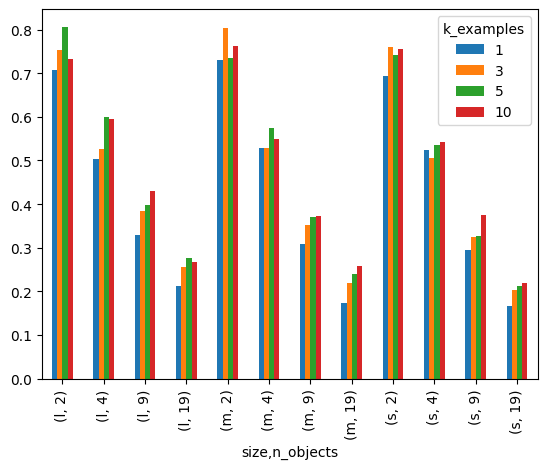

In [85]:
# make a graph of the breakdown
fig, ax = plt.subplots()
df_a.groupby(['size', 'n_objects', 'k_examples'])['correct'].mean().unstack().plot(kind='bar', ax=ax)

<Axes: xlabel='size,n_objects'>

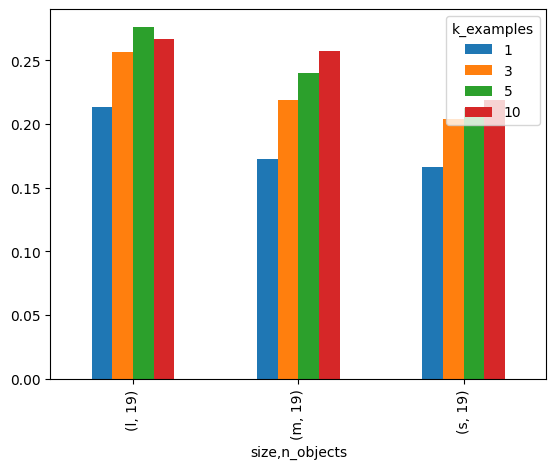

In [86]:
# make a graph of the breakdown
fig, ax = plt.subplots()
df_a[df_a["n_objects"] == 19].groupby(['size', 'n_objects', 'k_examples'])['correct'].mean().unstack().plot(kind='bar', ax=ax)

In [87]:
df.columns

Index(['repeat', 'seed', 'hand', 'blind', 'illuminated', 'torch',
       'volume_portrait', 'clutter', 'target_class', 'predicted_class',
       'predicted_prob', 'correct', 'prob_cls_0', 'prob_cls_1', 'prob_cls_2',
       'prob_cls_3', 'prob_cls_4', 'prob_cls_5', 'prob_cls_6', 'prob_cls_7',
       'prob_cls_8', 'prob_cls_9', 'prob_cls_10', 'prob_cls_11', 'prob_cls_12',
       'prob_cls_13', 'prob_cls_14', 'prob_cls_15', 'prob_cls_16',
       'prob_cls_17', 'prob_cls_18', 'size', 'train blind', 'train clutter',
       'train hand', 'n_objects', 'k_examples', 'augment', 'WC',
       'target class name'],
      dtype='object')

<Axes: xlabel='target class name'>

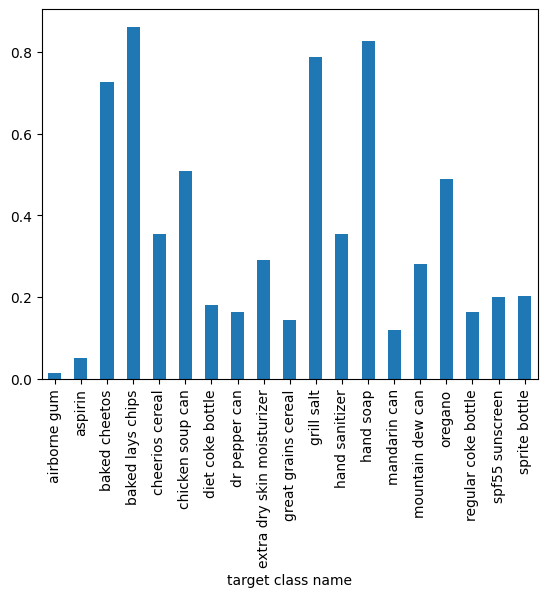

In [88]:
# make a graph of the accuracy by target_class for the model size l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['target class name'])['correct'].mean().plot(kind='bar', ax=ax)

<Axes: xlabel='train blind'>

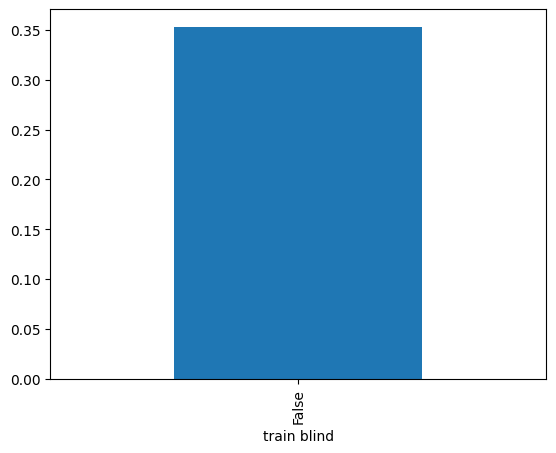

In [89]:
# make a graph of the accuracy according to the blind attribute for the model l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['train blind'])['correct'].mean().plot(kind='bar', ax=ax)

<Axes: title={'center': 'correct'}, xlabel='train blind'>

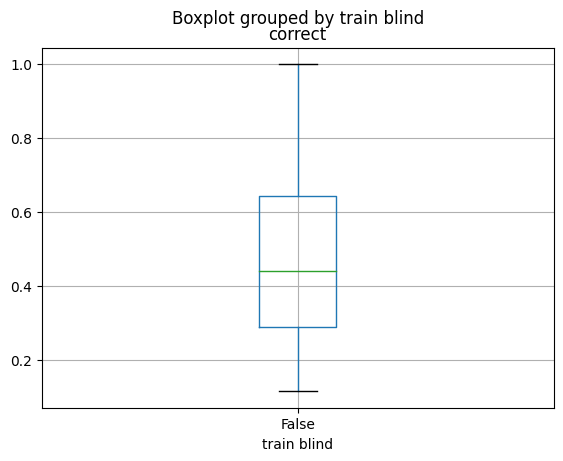

In [90]:
grouped_df = df_a[df_a['size'] == 'l'].groupby(['train blind', "seed"])['correct'].mean().reset_index()

fig, ax = plt.subplots()
grouped_df.boxplot(column='correct', by='train blind', ax=ax)

<Axes: xlabel='illuminated'>

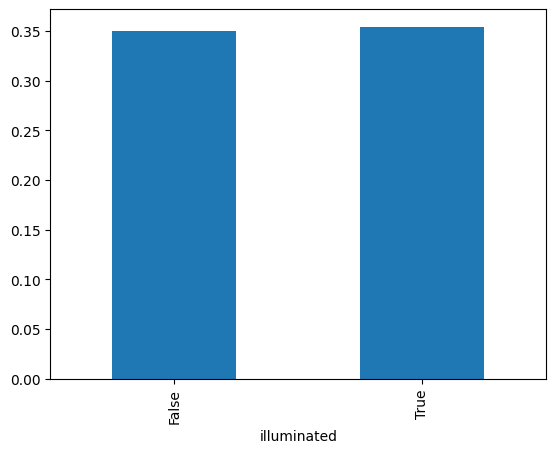

In [91]:
# make graph according to illumination still for the model l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['illuminated'])['correct'].mean().plot(kind='bar', ax=ax)

<Axes: xlabel='train hand'>

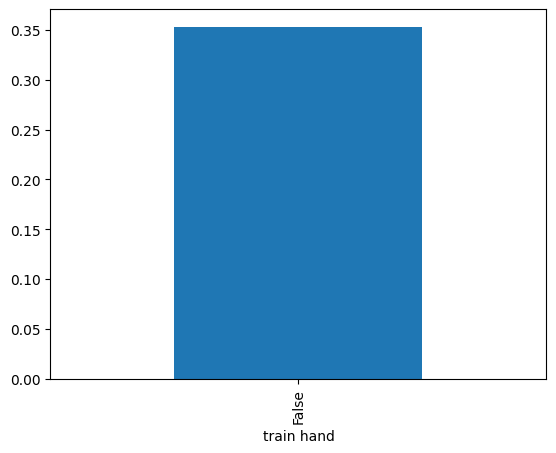

In [92]:
# make the same graph with hand or no hand, still for model l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['train hand'])['correct'].mean().plot(kind='bar', ax=ax)

In [93]:
df[df["n_objects"] == 9].groupby(["seed"])["correct"].mean()

seed
195579    0.334568
195580    0.327778
195581    0.442593
195582    0.430864
195583    0.406790
            ...   
969956    0.440123
969957    0.383333
969958    0.314198
969959    0.467284
969960    0.309877
Name: correct, Length: 360, dtype: float64

# Top-k accuracies

In [94]:
from sklearn.metrics import top_k_accuracy_score

In [95]:
def measure_topk(df, k=5):
    return top_k_accuracy_score(df["target_class"], df[prob_cols], k=k)

In [96]:
measure_topk(df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10)], k=3)

0.48914230019493177

In [97]:
((df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10)][prob_cols] > 0.9).sum(axis=1) > 1).mean()

0.00020467836257309941

In [98]:
((df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10)][prob_cols]/19).sum(axis=1) > 0.5).mean()

0.0

In [99]:
# compute the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def compute_confusion(df):
    cm = confusion_matrix(df["target_class"],
                        df[prob_cols].idxmax(axis=1).apply(lambda x: int(x.split("_")[-1])),
                        normalize=None)
    return cm

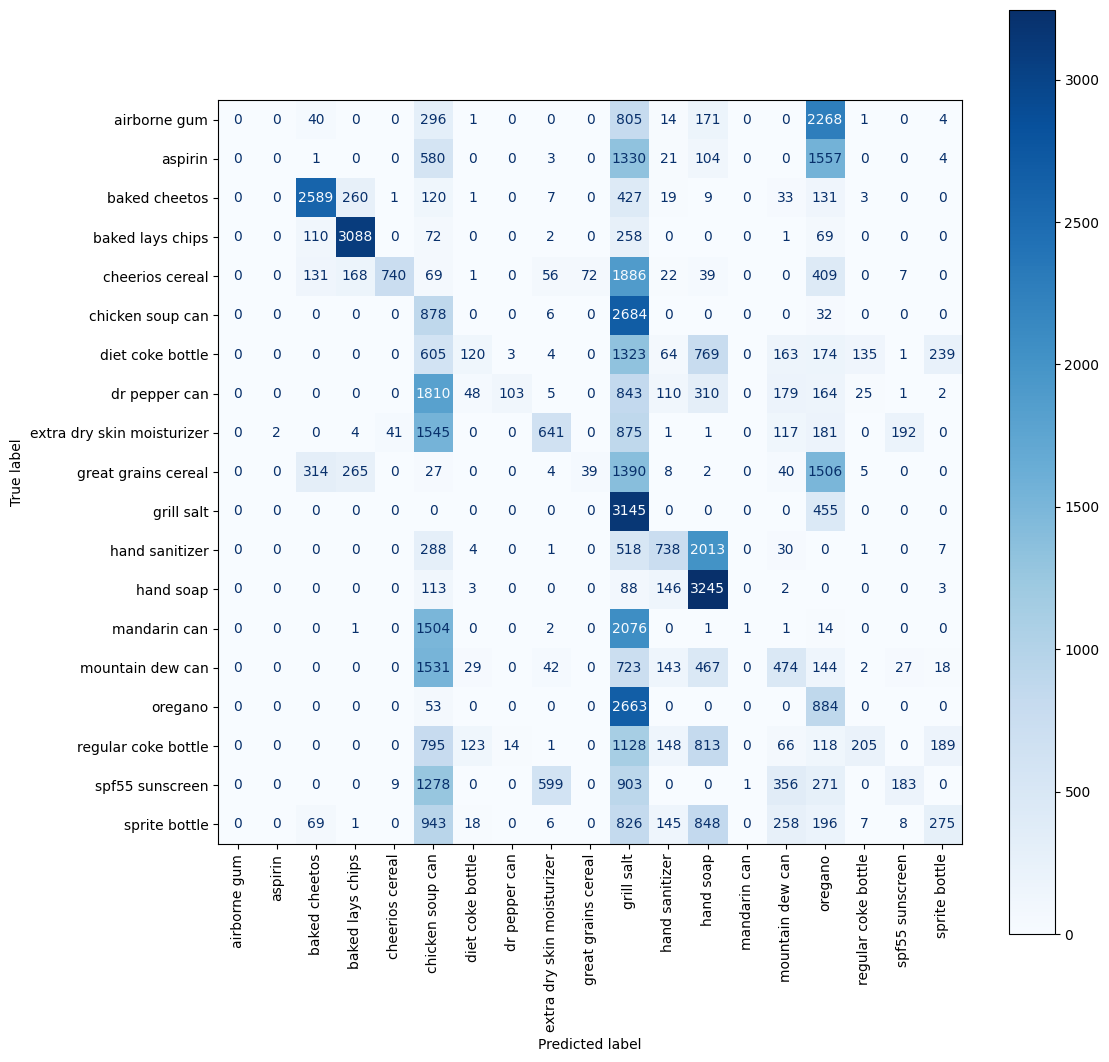

In [116]:
cm = compute_confusion(df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10) & (df_a["blind"] == False)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_mapping)

# make the plot larger
fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

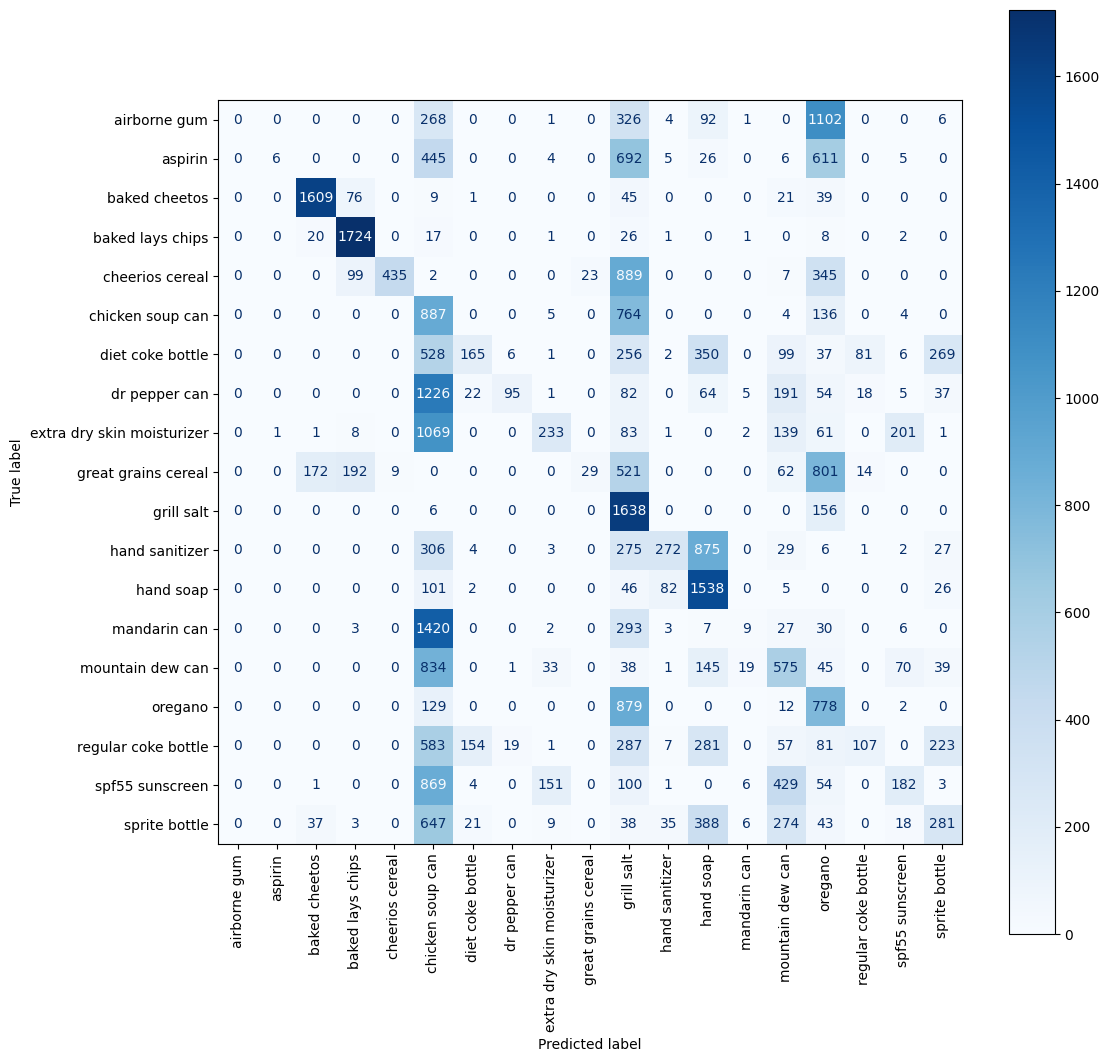

In [101]:
cm = compute_confusion(df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 5) & (df_a["blind"] == False) & (df_a["clutter"] == False)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_mapping)

# make the plot larger
fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

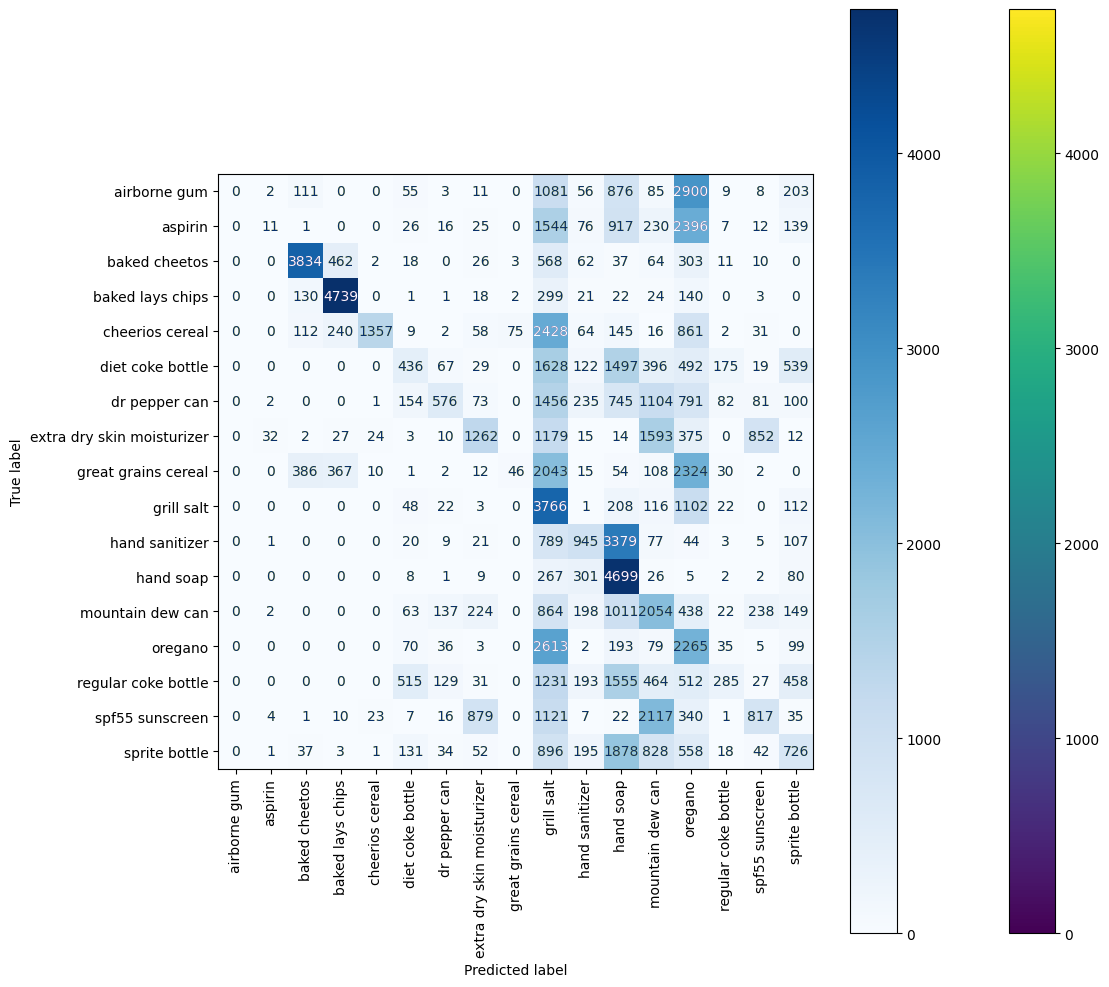

In [102]:
cmdf = df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 5)]

# make the plot larger
fig, ax = plt.subplots(figsize=(12, 12))

retained_labels = [i for i,c in enumerate(cls_mapping) if c not in ("chicken soup can", "mandarin can")]

disp = ConfusionMatrixDisplay.from_predictions(cmdf["target_class"],
        cmdf[[f"prob_cls_{i}" for i in retained_labels]].idxmax(axis=1).apply(lambda x: int(x.split("_")[-1])),
    display_labels=[cls_mapping[i] for i in retained_labels],
    labels=retained_labels,
    ax=ax,
    xticks_rotation='vertical',
    )

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)


In [103]:
df_a.groupby(["predicted_class"])["correct"].mean()

predicted_class
0     0.568851
1     0.391113
2     0.742751
3     0.761376
4     0.755049
5     0.215819
6     0.355026
7     0.536445
8     0.436767
9     0.574664
10    0.174324
11    0.310392
12    0.336325
13    0.326490
14    0.349317
15    0.159606
16    0.369500
17    0.358259
18    0.419437
Name: correct, dtype: float64

In [104]:
df_a.groupby(["target_class"])["correct"].mean()

target_class
0     0.016398
1     0.037762
2     0.441473
3     0.703570
4     0.336292
5     0.586786
6     0.210409
7     0.140974
8     0.322197
9     0.143832
10    0.711526
11    0.392655
12    0.744496
13    0.171949
14    0.279900
15    0.274192
16    0.193338
17    0.208531
18    0.298154
Name: correct, dtype: float64

In [105]:
# count number of prediction by predicted class
c = df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 5)].groupby(["predicted_class"]).size()
# display by class name
c.index = [cls_mapping[i] for i in c.index]
c / c.sum()

aspirin                       0.000468
baked cheetos                 0.044971
baked lays chips              0.056842
cheerios cereal               0.013830
chicken soup can              0.184737
diet coke bottle              0.013908
dr pepper can                 0.005448
extra dry skin moisturizer    0.016404
great grains cereal           0.001228
grill salt                    0.242242
hand sanitizer                0.021725
hand soap                     0.162359
mandarin can                  0.002349
mountain dew can              0.048840
oregano                       0.139415
regular coke bottle           0.006043
spf55 sunscreen               0.013938
sprite bottle                 0.025253
dtype: float64

In [106]:
# count number of prediction by predicted class
c = df_a.groupby(["predicted_class"]).size()
# display by class name
c.index = [cls_mapping[i] for i in c.index]
c

airborne gum                    3326
aspirin                        11140
baked cheetos                  69007
baked lays chips              113107
cheerios cereal                51790
chicken soup can              314194
diet coke bottle               68381
dr pepper can                  29990
extra dry skin moisturizer     87770
great grains cereal            28608
grill salt                    471673
hand sanitizer                141405
hand soap                     255408
mandarin can                   63610
mountain dew can               92884
oregano                       190175
regular coke bottle            61973
spf55 sunscreen                69045
sprite bottle                  79714
dtype: int64

In [107]:
df_a.columns

Index(['repeat', 'seed', 'hand', 'blind', 'illuminated', 'torch',
       'volume_portrait', 'clutter', 'target_class', 'predicted_class',
       'predicted_prob', 'correct', 'prob_cls_0', 'prob_cls_1', 'prob_cls_2',
       'prob_cls_3', 'prob_cls_4', 'prob_cls_5', 'prob_cls_6', 'prob_cls_7',
       'prob_cls_8', 'prob_cls_9', 'prob_cls_10', 'prob_cls_11', 'prob_cls_12',
       'prob_cls_13', 'prob_cls_14', 'prob_cls_15', 'prob_cls_16',
       'prob_cls_17', 'prob_cls_18', 'size', 'train blind', 'train clutter',
       'train hand', 'n_objects', 'k_examples', 'augment', 'WC',
       'target class name'],
      dtype='object')

In [108]:
target_cls_probs = df_a.apply(lambda x: x["prob_cls_" + str(x["target_class"])], axis=1)

In [109]:
df_a["target_class"].iloc[102600], df_a["prob_cls_9"].iloc[102600]

(18, 0.0013477484462782)

In [110]:
target_cls_probs.iloc[102600]

0.0214045159518718

In [111]:
prob_abs_diff = df_a[prob_cols].apply(lambda x: np.abs(x.to_numpy() - target_cls_probs.to_numpy()))

In [112]:
prob_diff = df_a["predicted_prob"] - target_cls_probs

<Axes: >

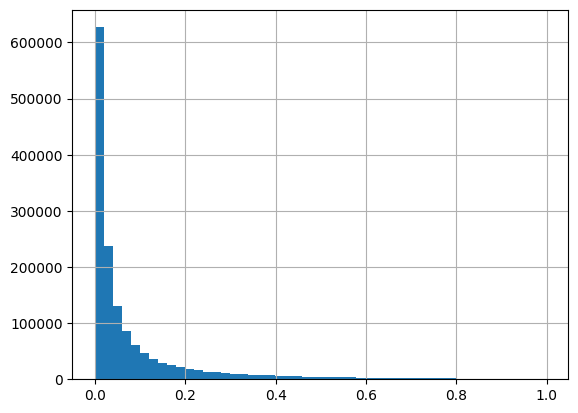

In [113]:
fig, ax = plt.subplots()
prob_diff[df_a["correct"] == False].hist(bins=50, ax=ax)

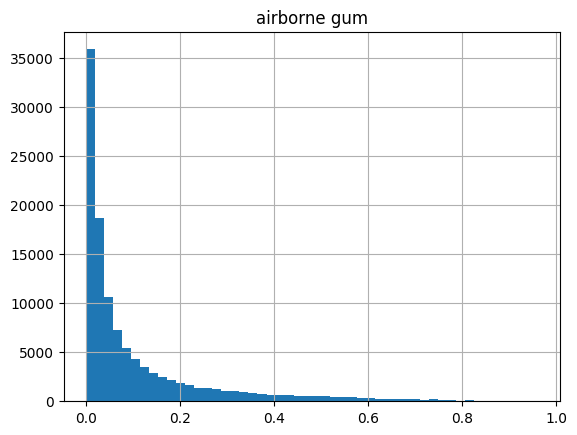

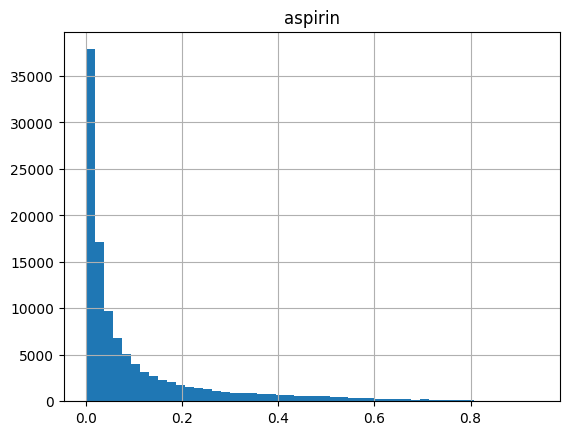

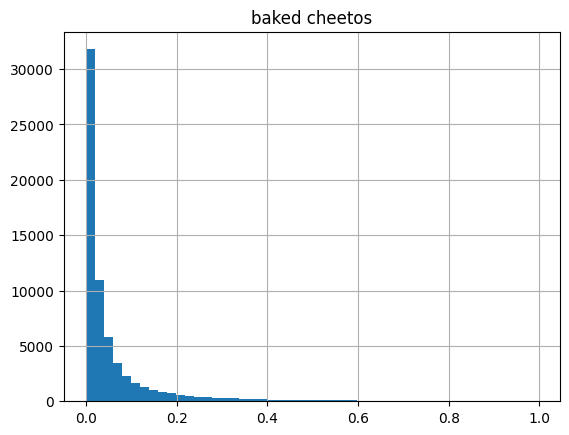

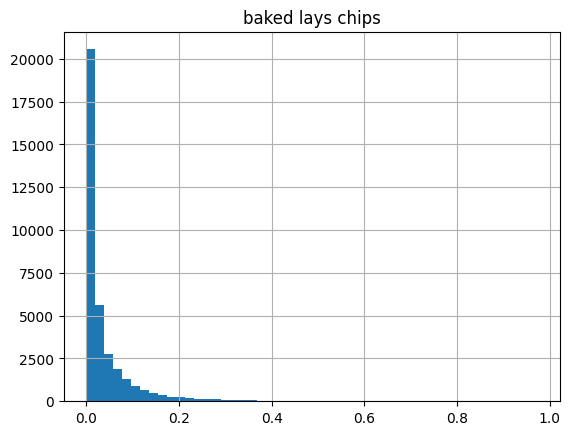

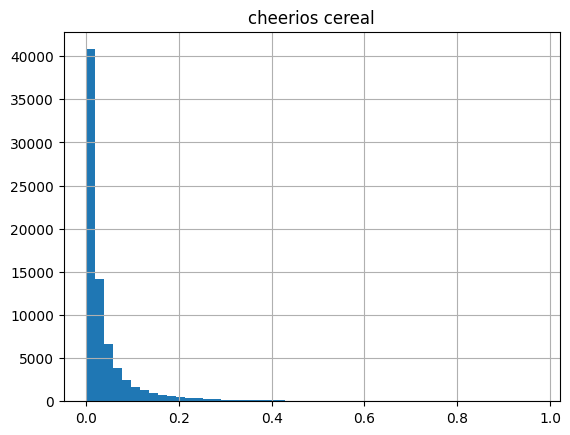

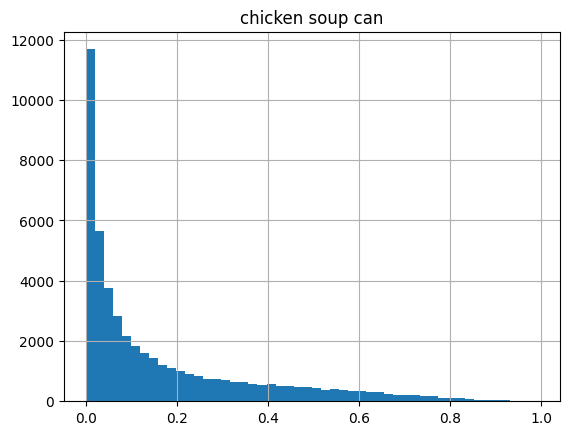

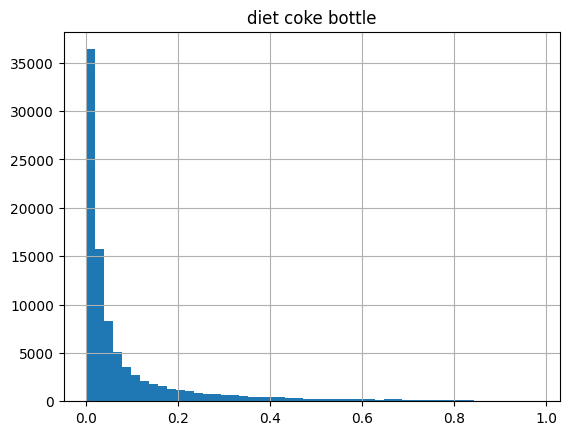

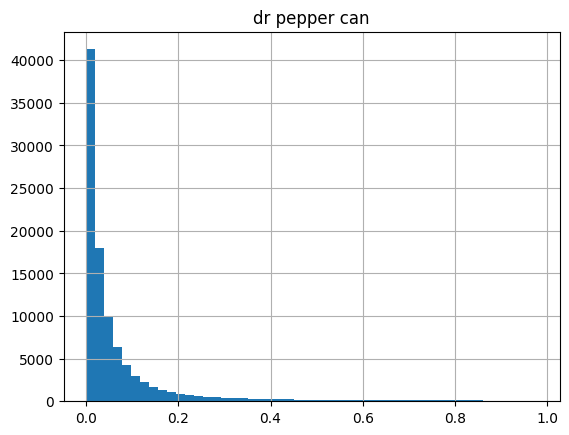

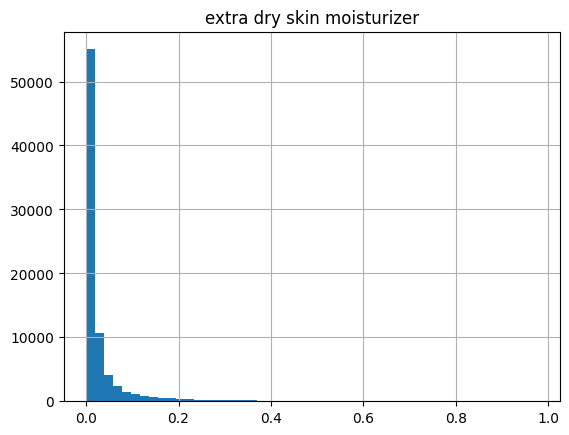

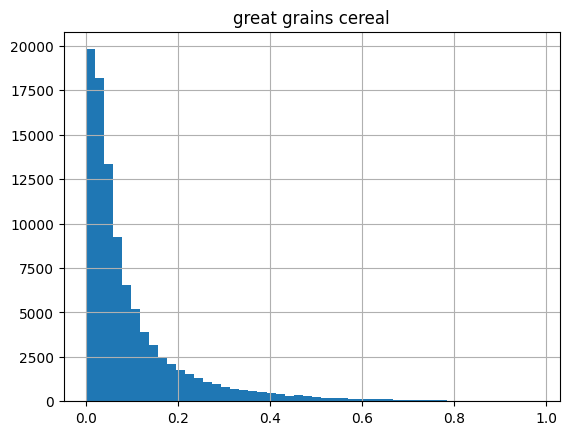

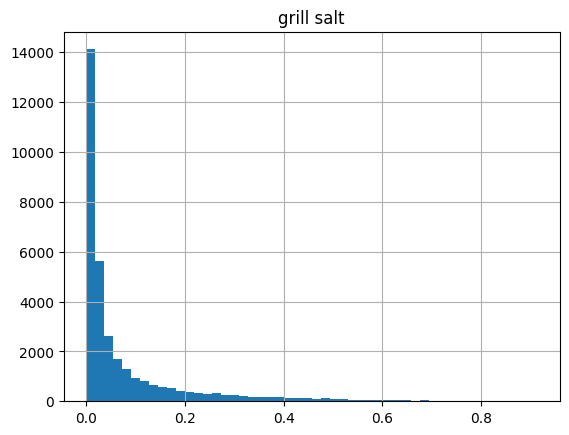

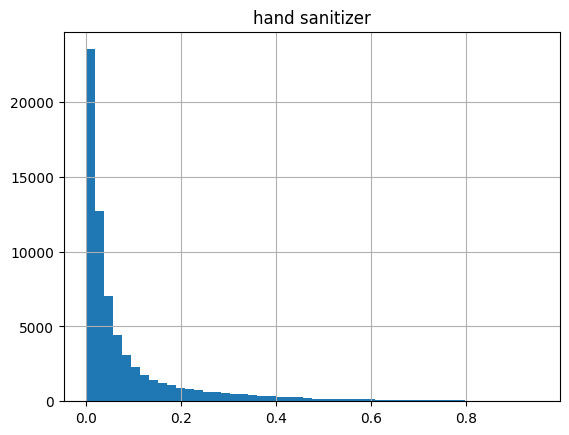

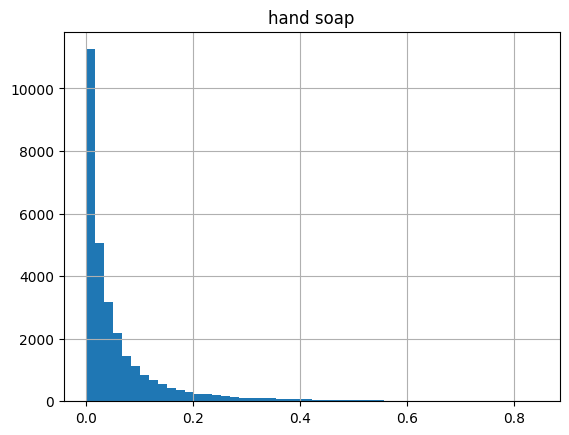

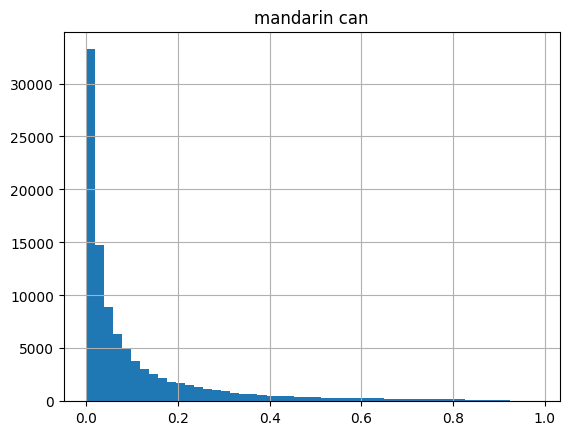

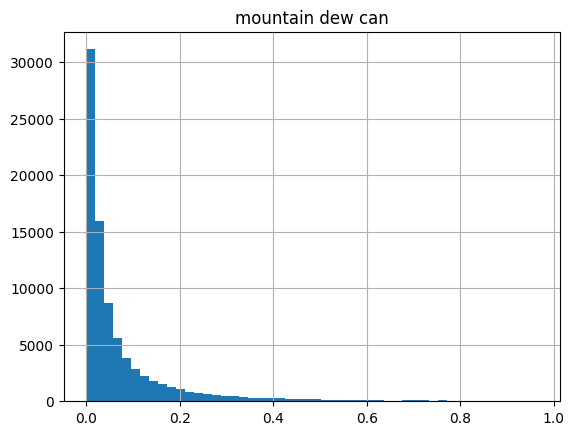

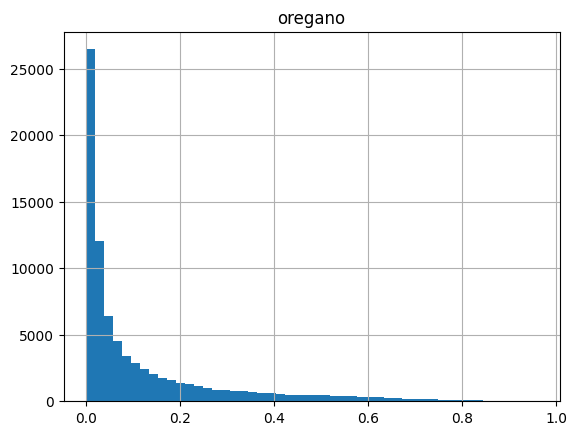

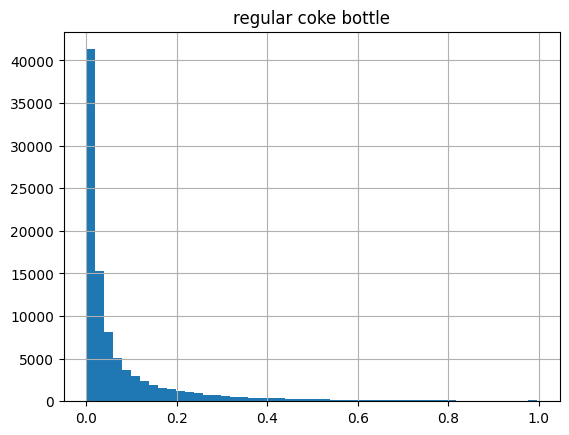

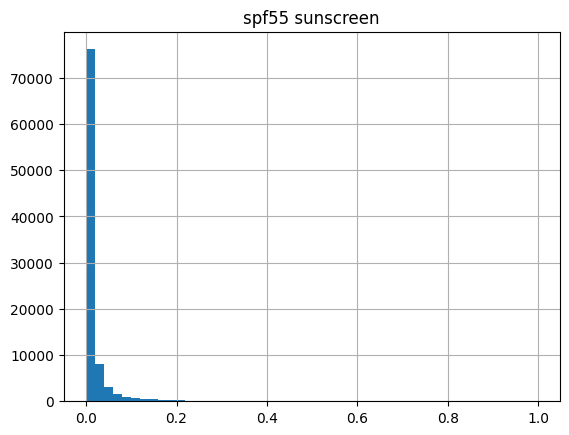

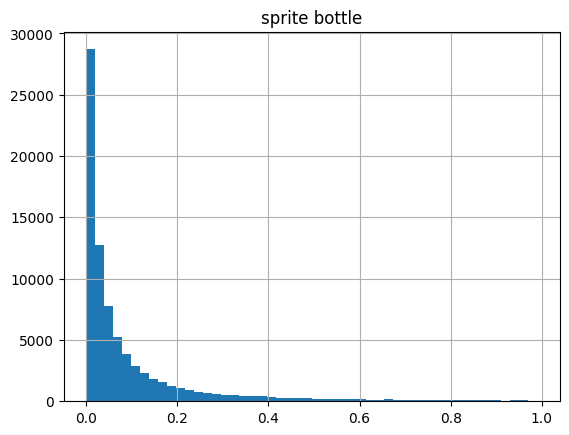

In [114]:
# plot for each class
for i in range(19):
    fig, ax = plt.subplots()
    # [f"prob_cls_{i}"]
    prob_diff[(df_a["correct"] == False) & (df_a["target_class"] == i)].hist(bins=50, ax=ax)
    plt.title(cls_mapping[i])